In [ ]:
#!/usr/bin/env python3

import os
from random import randint, random

import h5py
import numpy as np
from PIL import Image, ImageDraw


def generate(dir_name, num_imgs):
    # `torchvision.datasets.ImageFolder` requires a subfolder
    os.makedirs(f'./msds2/{dir_name}/0', exist_ok=True)

    labels = np.empty((num_imgs, 4, 4, 6), dtype=np.int32)
    for count in range(num_imgs):
        item_angle = random() * 180

        img = Image.new('RGB', (32, 32), (0, 0, 0))
        for i in range(4):
            for j in range(4):
                item = Image.new('RGBA', (8, 8), (255, 255, 255, 0))
                draw = ImageDraw.Draw(item)

                now_color = (
                    randint(0, 255),
                    randint(0, 255),
                    randint(0, 255),
                    255,
                )
                draw.ellipse((1, 3, 7, 5), now_color)
                now_angle = item_angle + random() * 45
                item = item.rotate(now_angle,
                                   resample=Image.Resampling.BICUBIC)

                now_pos = (
                    i * 8 + randint(-1, 1),
                    j * 8 + randint(-1, 1),
                )
                img.paste(item, now_pos, mask=item)

                label = now_pos + (now_angle, ) + now_color[:3]
                labels[count, i, j, :] = label

        img.save(f'./msds2/{dir_name}/0/{count:05d}.png', compress_level=1)

    with h5py.File(f'./msds2/{dir_name}_labels.hdf5', 'w') as f:
        f.create_dataset('labels',
                         data=labels,
                         compression='gzip',
                         shuffle=True)


def main():
    generate('train', 9 * 10**4)
    generate('test', 10**4)


if __name__ == '__main__':
    main()


In [ ]:
# msds1_dataset.py
import os
from pathlib import Path
from typing import Tuple, Optional, Callable

import h5py
import numpy as np
from PIL import Image

import torch
from torch.utils.data import Dataset

batch_size = 512

class MSDS2(Dataset):
    """
    Minimal PyTorch-style wrapper around the dataset generated by your script.

    • Each sample returns:
        img   –   torch.Tensor   (C, H, W)   –   by default in [0,1]
        label –   torch.Tensor   (4, 4, 6)   –   (x, y, angle, R, G, B)
    """

    def __init__(
        self,
        root: str | Path = "./msds1",
        split: str = "train",            # "train" | "test"
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
        preload_labels: bool = True,     # load the entire HDF5 once; fine for 90k × 96 ints ≈ 35 MB
    ):
        super().__init__()

        split = split.lower()
        if split not in {"train", "test"}:
            raise ValueError(f"split must be 'train' or 'test', got {split!r}")

        self.img_dir = Path(root) / split / "0"
        self.img_paths = sorted(self.img_dir.glob("*.png"))          # 00000.png, 00001.png, …
        if not self.img_paths:
            raise FileNotFoundError(f"No images found in {self.img_dir}")

        # ------ labels ------------------------------------------------------
        h5_path = Path(root) / f"{split}_labels.hdf5"
        if not h5_path.exists():
            raise FileNotFoundError(h5_path)

        if preload_labels:
            with h5py.File(h5_path, "r") as f:
                self.labels = torch.from_numpy(f["labels"][...])     # (N, 4, 4, 6)
        else:
            # keep only the path; open lazily in __getitem__
            self.labels = None
            self._h5_path = h5_path

        # ------ optional transforms ----------------------------------------
        from torchvision.transforms import ToTensor
        self.transform = transform or ToTensor()
        self.target_transform = target_transform

    def __len__(self) -> int:
        return len(self.img_paths)

    # --------------------------------------------------------------------- #
    def _lazy_load_label(self, idx: int) -> torch.Tensor:
        """Open the HDF5 file every time (safer with num_workers>0)."""
        with h5py.File(self._h5_path, "r") as f:
            arr = f["labels"][idx]                   # (4, 4, 6) ndarray
        return torch.from_numpy(arr)

    # --------------------------------------------------------------------- #
    def __getitem__(self, idx: int) -> Tuple[torch.Tensor, torch.Tensor]:
        # --- image ---------------------------------------------------------
        img = Image.open(self.img_paths[idx]).convert("RGB")         # (32×32)
        if self.transform:
            img = self.transform(img)                                # torch.FloatTensor

        # --- label ---------------------------------------------------------
        if self.labels is not None:                                  # pre-loaded
            target = self.labels[idx]
        else:                                                        # lazy path
            target = self._lazy_load_label(idx)

        if self.target_transform:
            target = self.target_transform(target)

        return img, target


In [ ]:
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor, Normalize, Compose

# -- transforms --------------------------------------------------------------
transforms = Compose([
    ToTensor()                         # PIL → [0,1] tenso
])

# -- datasets & loaders ------------------------------------------------------
train_ds = MSDS2(root="./msds2", split="train", transform=transforms)
test_ds  = MSDS2(root="./msds2", split="test",  transform=transforms)

train_loader = DataLoader(
    train_ds,
    batch_size=batch_size,
    shuffle=True,
    num_workers=12,
    pin_memory=True,
)

# ---- quick sanity check ----------------------------------------------------
images, labels = next(iter(train_loader))
print(images.shape)   # torch.Size([128, 3, 32, 32])
print(labels.shape)   # torch.Size([128, 4, 4, 6])


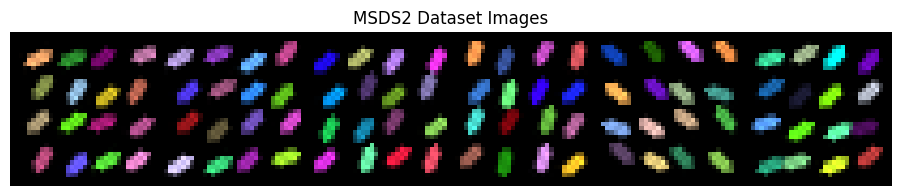

In [ ]:
import matplotlib.pyplot as plt
import torchvision

def show_images(data_loader, num_images: int = 6, *, denorm=None):
    """
    Visualise `num_images` images from the first batch in `data_loader`.

    Args
    ----
    data_loader : torch.utils.data.DataLoader
        Your existing loader (train or val).
    num_images  : int
        How many images from the batch to plot (<= batch_size).
    denorm : callable or None
        Optionally reverse any normalisation applied in your transforms.
        Example:
            denorm = lambda x: x * 0.5 + 0.5        # if you used Normalize(mean=.5, std=.5)
    """
    # Grab one batch; no need to exhaust the iterator
    images, labels = next(iter(data_loader))       # labels ignored for plotting
    images = images[:num_images].cpu()

    if denorm is not None:
        images = denorm(images)

    # torchvision.utils.make_grid puts them into one canvas
    grid = torchvision.utils.make_grid(
        images, nrow=num_images, padding=2, normalize=False
    )
    grid = grid.permute(1, 2, 0).numpy()           # (C,H,W) → (H,W,C) for matplotlib

    plt.figure(figsize=(2 * num_images, 2))
    plt.imshow(grid)
    plt.title(f"MSDS2 Dataset Images")
    plt.axis("off")
    plt.show()
show_images(train_loader)

In [ ]:
from torch.nn import init
from torch.utils.checkpoint import checkpoint
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CelebA
from torch.utils.data import DataLoader
import torch.distributions as D
import os
from torch.nn.utils.parametrizations import weight_norm
from torch.profiler import profile, record_function, ProfilerActivity, schedule
from contextlib import nullcontext # Used to conditionally disable the profiler
from torch.utils.checkpoint import checkpoint
from math import sqrt, log
from typing import List, Tuple, Dict, Any, Optional, Union
import time
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_float32_matmul_precision('high')

In [ ]:
import torch
import torch.nn as nn
from torch.nn.utils import weight_norm
from math import sqrt


class Swish(nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.alpha = nn.Parameter(torch.ones(num_features))

    def forward(self, x):
        return x * torch.sigmoid(self.alpha * x)


class ResNet(nn.Module):
    def __init__(self, nres = 4, widths = [48, 512, 512, 48], final_scale = True):
        assert widths[0] == widths[-1]

        super().__init__()
        self.res_blocks = nn.ModuleList(
            [self.build_res_block(widths) for _ in range(nres)])

        if final_scale:
            self.scale = nn.Parameter(torch.zeros(widths[-1]))
        else:
            self.scale = None

    def build_linear(self, in_features, out_features):
        linear = nn.Linear(in_features, out_features)
        bound = sqrt(2.81 * 3 / in_features)
        nn.init.uniform_(linear.weight, -bound, bound)
        nn.init.zeros_(linear.bias)
        linear = weight_norm(linear)
        return linear

    def build_res_block(self, widths):
        layers = []
        for i in range(len(widths) - 1):
            layers.append(Swish(widths[i]))
            layers.append(self.build_linear(widths[i], widths[i + 1]))
        return nn.Sequential(*layers)

    def forward(self, x):
        for res_block in self.res_blocks:
            x = (x + res_block(x)) / sqrt(2)

        if self.scale is not None:
            x = x * self.scale

        return x


class ResidualNetwork(ResNet):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def forward(self, x):
        shape = x.shape  # (B*num_RG_blocks, C, K, K)
        x = x.view(shape[0], -1)  # (B*num_RG_blocks, C*K*K)
        x = super().forward(x)
        x = x.view(shape)
        return x

In [ ]:
def create_masks(kernel_size: int, num_channels:int) -> Tuple[torch.Tensor, torch.Tensor]:
    '''
    Create checkerboard masks for the RNVP block.
    Args:
        kernel_size: The size of the kernel
        num_channels: The number of channels in the input
    Returns:
        mask: The mask for the networks
        comask: The complementary mask such that mask + comask = 1
    '''
    checkerboard = torch.from_numpy(np.indices((kernel_size, kernel_size)).sum(axis=0) % 2).float()
    mask = checkerboard.unsqueeze(0).repeat(num_channels, 1, 1)
    comask = 1 - mask
    return mask, comask

class RNVPBlock(nn.Module):
    mask: torch.Tensor
    comask: torch.Tensor

    def __init__(
        self,
        kernel_size: int,
        num_channels: int,
        s_nets: List[nn.Module],
        t_nets: List[nn.Module],
        *,
        apply_tanh: bool = True,
        use_ckpt: bool  = True,
    ):
        super().__init__()
        assert len(s_nets) == len(t_nets), "Need the same number of s and t networks"
        self.s_nets  = nn.ModuleList(s_nets)
        self.t_nets  = nn.ModuleList(t_nets)
        self.apply_tanh = apply_tanh
        self.use_ckpt   = use_ckpt

        mask, comask = create_masks(kernel_size, num_channels)
        self.register_buffer("mask",   mask)        # (C,H,W)
        self.register_buffer("comask", comask)


    def _checkpoint(self, fn, x):
        if self.training and self.use_ckpt and x.requires_grad:
            return checkpoint(fn, x, use_reentrant=False)   # saves memory
        else:
            return fn(x)

    def _one_forward_flow(
        self, x: torch.Tensor, s_net: nn.Module, t_net: nn.Module
    ) -> Tuple[torch.Tensor, torch.Tensor]:

        x1, x2 = x * self.mask, x * self.comask

        # step 1: mask -> comask
        s1 = self.comask * self._checkpoint(s_net, x1)
        t1 = self.comask * self._checkpoint(t_net, x1)
        if self.apply_tanh:  s1 = torch.tanh(s1)
        x2_ = self.comask * (torch.exp(s1) * x2 + t1)
        ldj  = s1.sum(dim=(1, 2, 3))

        # step 2: comask -> mask
        s2 = self.mask * self._checkpoint(s_net, x2_)
        t2 = self.mask * self._checkpoint(t_net, x2_)
        if self.apply_tanh:  s2 = torch.tanh(s2)
        x1_ = self.mask * (torch.exp(s2) * x1 + t2)
        ldj += s2.sum(dim=(1, 2, 3))

        return x1_ + x2_, ldj

    def _one_inverse_flow(
        self, x: torch.Tensor, s_net: nn.Module, t_net: nn.Module
    ) -> Tuple[torch.Tensor, torch.Tensor]:

        x1, x2 = x * self.mask, x * self.comask

        # step 2⁻¹
        s2 = self.mask * self._checkpoint(s_net, x2)
        t2 = self.mask * self._checkpoint(t_net, x2)
        if self.apply_tanh:  s2 = torch.tanh(s2)
        x1_ = self.mask * torch.exp(-s2) * (x1 - t2)
        ldj  = -s2.sum(dim=(1, 2, 3))

        # step 1⁻¹
        s1 = self.comask * self._checkpoint(s_net, x1_)
        t1 = self.comask * self._checkpoint(t_net, x1_)
        if self.apply_tanh:  s1 = torch.tanh(s1)
        x2_ = self.comask * torch.exp(-s1) * (x2 - t1)
        ldj -= s1.sum(dim=(1, 2, 3))

        return x1_ + x2_, ldj

    def forward(self, x):
        ldj = torch.zeros(x.size(0), device=x.device)
        for s_net, t_net in zip(self.s_nets, self.t_nets):
            x, inc = self._one_forward_flow(x, s_net, t_net)
            ldj += inc
        return x, ldj

    def inverse(self, z):
        ldj = torch.zeros(z.size(0), device=z.device)
        for s_net, t_net in zip(reversed(self.s_nets), reversed(self.t_nets)):
            z, inc = self._one_inverse_flow(z, s_net, t_net)
            ldj += inc
        return z, ldj


In [ ]:
def shift_kernel_blocks(x: torch.Tensor, m: int, h:int, inverse : bool = False) -> torch.Tensor:
    shift = (m // 2) * (2 ** h)
    if not inverse:
        return torch.roll(x, shifts=(-shift, -shift), dims=(-2, -1))
    else:
        return torch.roll(x, shifts=(shift, shift), dims=(-2, -1))

class MERABlock(nn.Module):
    def __init__(self, m, h, network, shift=False):
        super().__init__()
        self.m = m
        self.h = h
        self.network = network # Should have forward and inverse methods
        self.dilation = 2 ** h
        self.stride = m * self.dilation
        self.unfold = nn.Unfold(kernel_size=m, dilation=self.dilation, stride=self.stride)
        self.fold = None
        self.shift = shift
        self.cached_mask = None

    def _apply_flow(self, x, flow_method):
        B, C, H, W = x.shape

        x_orig = x
        x_to_process = x
        if self.shift:
            x_to_process = shift_kernel_blocks(x, self.m, self.h)

        patches = self.unfold(x_to_process)

        num_patches = patches.shape[-1]
        patches_reshaped = patches.view(B, C, self.m, self.m, num_patches).permute(0, 4, 1, 2, 3).reshape(B * num_patches, C, self.m, self.m)

        # Apply the specified flow method (forward or inverse)
        transformed_patches, ldj = flow_method(patches_reshaped)

        transformed_patches_reshaped = transformed_patches.view(B, num_patches, C, self.m, self.m).permute(0, 2, 3, 4, 1).reshape(B, C * self.m * self.m, num_patches)

        if self.fold is None:
            self.fold = nn.Fold(output_size=(H, W), kernel_size=self.m, dilation=self.dilation, stride=self.stride)
            with torch.no_grad():
                single_item_patches = patches.narrow(0, 0, 1)
                self.cached_mask = self.fold(torch.ones_like(single_item_patches))

        folded = self.fold(transformed_patches_reshaped)

        mask = self.cached_mask.expand(B, C, H, W)

        if self.shift:
            folded = shift_kernel_blocks(folded, self.m, self.h, inverse=True)
            mask = shift_kernel_blocks(mask, self.m, self.h, inverse=True)

        x_updated = torch.where(mask.bool(), folded, x_orig)

        return x_updated, ldj.view(B, -1).sum(dim=1)

    def forward(self, x):
        return self._apply_flow(x, self.network.forward)

    def inverse(self, x):
        return self._apply_flow(x, self.network.inverse)

class RG_Flow(nn.Module):
    """A full MERA model built from a sequence of MERABlock layers."""
    def __init__(self, layers):
        super().__init__()
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        ldj = torch.zeros(x.shape[0], device=x.device)
        for layer in self.layers:
            x, ldj_ = layer.forward(x)
            ldj += ldj_
        return x, ldj

    def inverse(self, x):
        ldj = torch.zeros(x.shape[0], device=x.device)
        for layer in reversed(self.layers):
            x, ldj_ = layer.inverse(x)
            ldj += ldj_
        return x, ldj

In [ ]:
class PriorDistribution(nn.Module):
    def __init__(self, dist_type='laplace'):
        super().__init__()
        if dist_type == 'laplace':
            self.base_dist = D.Laplace
        elif dist_type == 'gaussian':
            self.base_dist = D.Normal
        else:
            raise ValueError(f"Unsupported distribution type: {dist_type}")

    def __repr__(self):
        return f"PriorDistribution(dist_type={self.base_dist.__name__})"

    def log_prob(self, z, temperature=1.0):
        dist = self.base_dist(loc=torch.zeros_like(z), scale=torch.ones_like(z) * temperature)
        return dist.log_prob(z).sum(dim=[1, 2, 3]) # Sum over all dimensions except batch

    def sample(self, shape, temperature=1.0):
        dist = self.base_dist(loc=torch.zeros(shape), scale=torch.ones(shape) * temperature)
        return dist.sample()

In [ ]:
n_layers = [4, 4, 4, 4, 4, 4, 4, 4]

layers = []
for n in n_layers:
    s_nets = [ResidualNetwork() for _ in range(n)]
    t_nets = [ResidualNetwork() for _ in range(n)]
    layers.append(RNVPBlock(kernel_size=4, num_channels=3, s_nets=s_nets, t_nets=t_nets, apply_tanh=True, use_ckpt=True))

MERA_layers = []
for i, layer in enumerate(layers):
    MERA_layers.append(
        MERABlock(m=4, h = i // 2, network=layer, shift=(i % 2 == 1))
    )
flow = RG_Flow(MERA_layers)
flow.to(DEVICE)

In [ ]:
def logit_transform(x, dequant=True, constraint=0.9, inverse=False):
    if inverse:
        logit_x = x
        pre_logit_scale = torch.tensor(log(constraint) - log(1 - constraint))
        ldj = (F.softplus(logit_x) + F.softplus(-logit_x) -
               F.softplus(-pre_logit_scale))
        ldj = ldj.view(ldj.shape[0], -1).sum(dim=1)
        x = 1 / (1 + torch.exp(-logit_x))
        x *= 2
        x -= 1
        x /= constraint
        x += 1
        x /= 2

        return x, ldj

    else:
        if dequant:
            noise = torch.rand_like(x)
            x = (x * 255 + noise) / 256

        x *= 2
        x -= 1
        x *= constraint
        x += 1
        x /= 2

        logit_x = torch.log(x) - torch.log(1 - x)

        pre_logit_scale = torch.tensor(log(constraint) - log(1 - constraint))
        ldj = (F.softplus(logit_x) + F.softplus(-logit_x) -
               F.softplus(-pre_logit_scale))
        ldj = ldj.view(ldj.shape[0], -1).sum(dim=1)

        return logit_x, ldj

In [ ]:
def generate_and_show_images(
    model: RG_Flow,
    prior: PriorDistribution,
    epoch: int,
    num_images: int,
    image_dims: tuple,
    device: str,
    save_dir: str = "generated_images"
):
    """
    Generates images from the model, displays them, and saves them to a file.

    Args:
        model: The RG_Flow model instance.
        prior: The prior distribution.
        epoch: The current epoch number (for titling and saving).
        num_images: The number of images to generate.
        image_dims: A tuple of (channels, height, width).
        device: The device to run generation on.
        save_dir: Directory to save the generated images.
    """

    model.eval()


    os.makedirs(save_dir, exist_ok=True)

    with torch.no_grad():

        n_channels, height, width = image_dims
        z_shape = (num_images, n_channels, height, width)
        z = prior.sample(z_shape).to(device)


        generated_logits, _ = model.inverse(z)


        generated_images, _ = logit_transform(generated_logits, dequant=False, inverse=True)


        generated_images = generated_images.cpu()


        generated_images = torch.clamp(generated_images, 0, 1)


    grid = torchvision.utils.make_grid(generated_images, nrow=int(sqrt(num_images)))
    img_grid = grid.permute(1, 2, 0).numpy()

    plt.figure(figsize=(8, 8))
    plt.imshow(img_grid)
    plt.title(f"Generated Images at Epoch {epoch + 1}")
    plt.axis('off')


    plt.savefig(os.path.join(save_dir, f"epoch_{epoch+1:03d}.png"))
    plt.show()


    model.train()

In [ ]:
import logging
import time
from datetime import datetime

def setup_logger(name='rg_flow_training'):
    """
    Sets up a logger that writes to a file and the console.
    """
    # Create a logger
    logger = logging.getLogger(name)
    logger.setLevel(logging.INFO) # Set the minimum level of messages to log

    # Prevent the logger from propagating to the root logger
    logger.propagate = False

    # Create a formatter
    formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s',
                                  datefmt='%Y-%m-%d %H:%M:%S')

    # --- File Handler ---
    # Create a unique log file name with a timestamp
    log_filename = f"training_run_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.log"
    file_handler = logging.FileHandler(log_filename)
    file_handler.setFormatter(formatter)

    # --- Console Handler ---
    stream_handler = logging.StreamHandler() # Writes to console
    stream_handler.setFormatter(formatter)

    # Add handlers to the logger, but only if they haven't been added before
    if not logger.handlers:
        logger.addHandler(file_handler)
        logger.addHandler(stream_handler)

    return logger

In [ ]:
def train_rg_flow(
    model: RG_Flow,
    prior: PriorDistribution,
    train_loader: DataLoader,
    optimizer: torch.optim.Optimizer,
    num_epochs: int,
    device: str,
    image_dims: tuple,
    logger: logging.Logger,
    num_images_to_generate: int = 16
):
    """
    The main training loop for the RG-Flow model.
    ... (args documentation) ...
    Args:
        logger: A configured logger object.
    """
    model.train()
    model.to(device)
    prior.to(device)

    n_channels, height, width = image_dims
    bpd_factor = np.log(2) * n_channels * height * width
    logger.info(f"Training for {num_epochs} epochs...")
    logger.info(f"Batch size: {BATCH_SIZE}")
    logger.info(f"Learning rate: {LEARNING_RATE}")
    logger.info(f"Image dimensions: {image_dims}")
    logger.info(f"Number of images to generate: {num_images_to_generate}")
    logger.info(prior)

    logger.info("--- Starting Training ---")
    for epoch in range(num_epochs):
        epoch_start_time = time.time()
        total_loss = 0.0

        for batch_idx, (x, _) in enumerate(train_loader):
            optimizer.zero_grad()
            x = x.to(device)
            x, ldj_logit = logit_transform(x)
            z_final, ldj_combined = model.forward(x)
            logp_prior = prior.log_prob(z_final)
            total_log_likelihood = logp_prior + ldj_combined + ldj_logit
            loss = -torch.mean(total_log_likelihood)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1)
            optimizer.step()
            total_loss += loss.item()

            if batch_idx % 50 == 0: # Log less frequently for a cleaner file
                bpd = (loss.item() + np.log(256.) * (n_channels * height * width)) / bpd_factor
                logger.info(f"Epoch: {epoch+1}/{num_epochs} | Batch: {batch_idx}/{len(train_loader)} | Loss (NLL): {loss.item():.4f} | BPD: {bpd:.4f}")

        avg_loss = total_loss / len(train_loader)
        epoch_time = time.time() - epoch_start_time
        logger.info(f"--- Epoch {epoch+1} Summary ---")
        logger.info(f"Average Loss: {avg_loss:.4f} | Time: {epoch_time:.2f}s")

        logger.info("Generating sample images...")
        generate_and_show_images(
            model=model,
            prior=prior,
            epoch=epoch,
            num_images=num_images_to_generate,
            image_dims=image_dims,
            device=device
        )

        logger.info("-" * 30)

In [ ]:
IMAGE_SIZE = 32
NUM_CHANNELS = 3
BATCH_SIZE = batch_size
LEARNING_RATE = 1e-3
NUM_EPOCHS = 60
prior_str = "laplace"
prior = PriorDistribution(dist_type=prior_str)


logger = setup_logger()
optimizer = torch.optim.AdamW(flow.parameters(), lr=LEARNING_RATE, weight_decay=5e-5)


try:
    train_rg_flow(
        model=flow,
        prior=prior,
        train_loader=train_loader,
        optimizer=optimizer,
        num_epochs=NUM_EPOCHS,
        device=DEVICE,
        image_dims=(NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE),
        logger=logger,
        num_images_to_generate=16
    )
except Exception as e:
    logger.error("An error occurred during training!", exc_info=True)

In [ ]:
from google.colab import files
# Download the generated images directory
!zip -r generated_images.zip generated_images
files.download('generated_images.zip')
# Download the model weights file

In [ ]:

from datetime import datetime

# Create a timestamp for the filename
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
MODEL_WEIGHTS_PATH = f"rg_flow_weights_{timestamp}_{NUM_EPOCHS}_MSD2_{prior_str}.pth"

print(f"Saving model weights to {MODEL_WEIGHTS_PATH}...")

# Use model.state_dict() to get the dictionary of weights
torch.save(flow.state_dict(), MODEL_WEIGHTS_PATH)

print("Model weights saved successfully.")
files.download(MODEL_WEIGHTS_PATH)

In [ ]:


# Define the path for saving the optimizer state
optimizer_path = f"rg_flow_optimizer_{timestamp}_{NUM_EPOCHS}_MSD2_{prior_str}.pth"

print(f"Saving optimizer state to {optimizer_path}...")

# Save the state_dict of the optimizer
torch.save(optimizer.state_dict(), optimizer_path)

print("Optimizer state saved successfully.")

# Download the optimizer state file
files.download(optimizer_path)